# Detetct smoking man
This is a classification task to predict smokers based on clinical indications. You can solve it using any algorithm, but I think it will mostly be Catbust).

After simply launching a catboost, you can try to play around with the features and parameters of the model to get to first place. Don’t forget that a threshold of 0.5 will not necessarily be optimal: first set up the model using the ROC AUC and Average Precision metrics, and then select the optimal threshold to get the highest F1.

EDA (exploratory data analysis) and posting notebooks in the Code section are also encouraged.

The model's prediction will be assessed by the F-measure (F1). The F-measure is the harmonic average between precision and recall. The weights for precision and recall are set to the same.

In [1]:
!pip install -q catboost
!pip install -q tqdm
!pip install -q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 6.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, roc_auc_score, log_loss

from catboost import CatBoostClassifier, Pool, cv

from tqdm.autonotebook import tqdm

import phik

<ipython-input-2-40e3b6d580c4>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Download and read data

https://drive.google.com/file/d/1AOx2EfKZKzTCYpV4PInhZ9J3CJbKwbWg/view?usp=drive_link

In [3]:
! gdown 1AOx2EfKZKzTCYpV4PInhZ9J3CJbKwbWg
! unzip -o /content/leopard-challenge-classification.zip -d /content/smoke

Downloading...
From: https://drive.google.com/uc?id=1AOx2EfKZKzTCYpV4PInhZ9J3CJbKwbWg
To: /content/leopard-challenge-classification.zip
100% 639k/639k [00:00<00:00, 83.5MB/s]
Archive:  /content/leopard-challenge-classification.zip
  inflating: /content/smoke/sample_submission.csv  
  inflating: /content/smoke/test.csv  
  inflating: /content/smoke/train.csv  


In [4]:
df = pd.read_csv("/content/smoke/train.csv")
test = pd.read_csv("/content/smoke/test.csv")

# Verify data

In [5]:
df.columns

Index(['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'oral', 'dental caries', 'tartar', 'smoking'],
      dtype='object')

In [6]:
test.columns

Index(['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'oral', 'dental caries', 'tartar'],
      dtype='object')

# Format columns name

In [7]:
df.columns = df.columns.str.lower()
test.columns = test.columns.str.lower()

df.columns = [
    col.replace('(', '_').replace(')', '').replace(' ', '_')
    for col in df.columns
]

test.columns = [
    col.replace('(', '_').replace(')', '').replace(' ', '_')
    for col in test.columns
]

In [8]:
df.columns

Index(['id', 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'oral', 'dental_caries', 'tartar', 'smoking'],
      dtype='object')

In [9]:
df.dtypes

id                       int64
age                      int64
height_cm                int64
weight_kg                int64
waist_cm               float64
eyesight_left          float64
eyesight_right         float64
hearing_left           float64
hearing_right          float64
systolic               float64
relaxation             float64
fasting_blood_sugar    float64
cholesterol            float64
triglyceride           float64
hdl                    float64
ldl                    float64
hemoglobin             float64
urine_protein          float64
serum_creatinine       float64
ast                    float64
alt                    float64
gtp                    float64
oral                    object
dental_caries            int64
tartar                  object
smoking                  int64
dtype: object

In [10]:
df.isna().mean()

id                     0.0
age                    0.0
height_cm              0.0
weight_kg              0.0
waist_cm               0.0
eyesight_left          0.0
eyesight_right         0.0
hearing_left           0.0
hearing_right          0.0
systolic               0.0
relaxation             0.0
fasting_blood_sugar    0.0
cholesterol            0.0
triglyceride           0.0
hdl                    0.0
ldl                    0.0
hemoglobin             0.0
urine_protein          0.0
serum_creatinine       0.0
ast                    0.0
alt                    0.0
gtp                    0.0
oral                   0.0
dental_caries          0.0
tartar                 0.0
smoking                0.0
dtype: float64

In [11]:
test.isna().mean()

id                     0.0
age                    0.0
height_cm              0.0
weight_kg              0.0
waist_cm               0.0
eyesight_left          0.0
eyesight_right         0.0
hearing_left           0.0
hearing_right          0.0
systolic               0.0
relaxation             0.0
fasting_blood_sugar    0.0
cholesterol            0.0
triglyceride           0.0
hdl                    0.0
ldl                    0.0
hemoglobin             0.0
urine_protein          0.0
serum_creatinine       0.0
ast                    0.0
alt                    0.0
gtp                    0.0
oral                   0.0
dental_caries          0.0
tartar                 0.0
dtype: float64

In [12]:
df.smoking.mean()

0.20197648416648634

In [13]:
df.select_dtypes(include='object').columns

Index(['oral', 'tartar'], dtype='object')

In [14]:
df['oral'].nunique()

1

df['oral'] is constant and not usefull, should exclude from model learning.

In [15]:
df['tartar'].nunique()

2

# Phik correlation
## Check correlation between features

In [16]:
phik_overview = df.phik_matrix()
phik_overview['smoking'].sort_values(ascending=False).round(3)

interval columns not set, guessing: ['id', 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left', 'eyesight_right', 'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride', 'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast', 'alt', 'gtp', 'dental_caries', 'smoking']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable oral for analysis 1. Dropping this column
  warnings.warn(


smoking                1.000
triglyceride           0.191
age                    0.183
gtp                    0.143
hemoglobin             0.112
tartar                 0.104
dental_caries          0.089
waist_cm               0.063
serum_creatinine       0.056
hdl                    0.051
weight_kg              0.043
fasting_blood_sugar    0.042
hearing_left           0.035
height_cm              0.035
urine_protein          0.031
hearing_right          0.025
relaxation             0.023
ldl                    0.022
systolic               0.016
cholesterol            0.016
alt                    0.015
ast                    0.002
eyesight_right         0.000
eyesight_left          0.000
id                     0.000
Name: smoking, dtype: float64

In [17]:
def phik_corr_features(arr: list, feature: str) -> pd.DataFrame:
    '''
    The function is applied to enter the list of predictors,
    determines the date and time, where in the cells is the coefficient
    matching phik with built-in variable 'feature'
    '''
    table = df[arr + [feature]]\
    .phik_matrix()[feature].to_frame()\
    .sort_values(feature, ascending=False).round(2)
    return table.iloc[1:, :]

#Derived features
###These derived features can help the model better capture the relationships between various indicators and the target variable "smoking."
Each new metric to categorize into five groups: Very Good, Good, Average, Poor, and Very Poor. Keep in mind that these ranges are indicative, and based on this specific dataset and requirements. These ranges should help you categorize the derived metrics into the specified groups, allowing for further analysis or modeling based on the categorized data. Adjust the ranges as needed to fit the specific characteristics of your dataset and the context of your analysis.


##1. Body Mass Index (BMI):

   <b><i>BMI = weight(kg) / (height(cm) / 100)^2</i></b>

   BMI is an important indicator for analyzing the relationship between weight and height of an individual.

  Body Mass Index (BMI):
   - Very Good: < 18.5 (Underweight)
   - Good: 18.5 - 24.9 (Normal Weight)
   - Average: 25 - 29.9 (Overweight)
   - Poor: 30 - 34.9 (Obese Class I)
   - Very Poor: ≥ 35 (Obese Class II+)



In [18]:
phik_corr_features(['height_cm', 'weight_kg', 'waist_cm'], 'smoking')

interval columns not set, guessing: ['height_cm', 'weight_kg', 'waist_cm', 'smoking']


,smoking
waist_cm,0.06
weight_kg,0.04
height_cm,0.04


In [19]:
ch = df['weight_kg'] / (df['height_cm'] / 100)**2
ch.describe()

count    13863.000000
mean        24.726227
std          3.298263
min         14.692378
25%         22.491349
50%         24.221453
75%         26.234568
max         42.448980
dtype: float64

<Axes: >

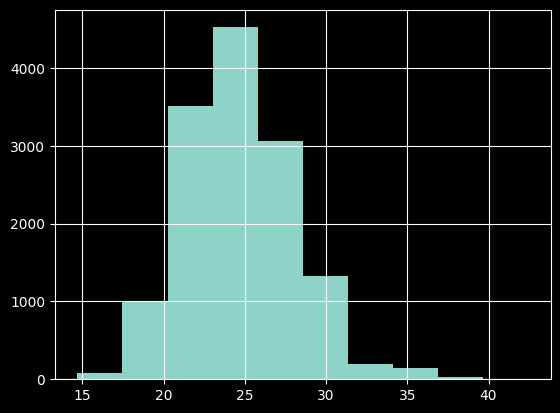

In [20]:
ch.hist()

In [21]:
def add_cat_bmi(df):

  df['bmi'] = df['weight_kg'] / (df['height_cm'] / 100)**2

  ranges = [0, 18.5, 24.9, 29.9, 34.9, float('inf')]
  categories = ['very_good', 'good', 'average', 'poor', 'very_poor']
  df['cat_bmi'] = pd.cut(df['bmi'], bins=ranges, labels=categories)


In [22]:
add_cat_bmi(df)
add_cat_bmi(test)

##2. Waist-to-Height Ratio:

   <b><i>waist_to_height_ratio = waist(cm) / height(cm)</i></b>

   This metric can be useful for assessing the relationship between waist circumference and height.

   Waist-to-Height Ratio:
   - Very Good: < 0.4
   - Good: 0.4 - 0.49
   - Average: 0.5 - 0.59
   - Poor: 0.6 - 0.69
   - Very Poor: ≥ 0.7


In [23]:
ch = df['waist_cm'] / df['height_cm']
ch.describe()

count    13863.000000
mean         0.500781
std          0.048848
min          0.318750
25%          0.467141
50%          0.497222
75%          0.531429
max          0.737500
dtype: float64

<Axes: >

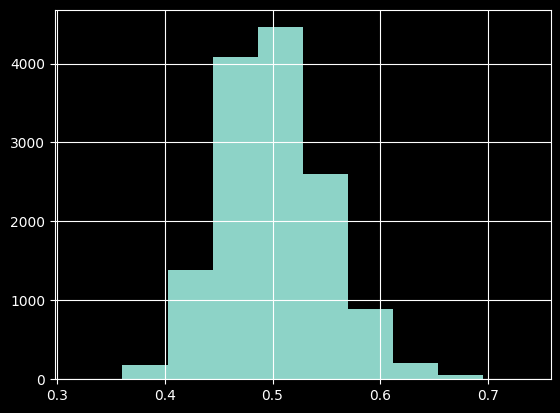

In [24]:
ch.hist()

In [25]:
def add_waist_to_height_ratio(df):
  df['waist_to_height_ratio'] = df['waist_cm'] / df['height_cm']
  ranges = [0, 0.4, 0.49, 0.59, 0.69, float('inf')]
  categories = ['very_good', 'good', 'average', 'poor', 'very_poor']
  df['cat_waist_to_height_ratio'] = pd.cut(df['waist_to_height_ratio'], bins=ranges, labels=categories)

In [26]:
add_waist_to_height_ratio(df)
add_waist_to_height_ratio(test)

##3. Blood Pressure:
   Create a new feature that combines systolic and diastolic blood pressure:

   <b><i>blood_pressure = systolic / relaxation</i></b>
   
   This can help the model account for the overall cardiovascular health.

   Blood Pressure (Systolic/Diastolic Ratio):
   - Very Good: < 0.9
   - Good: 0.9 - 1.2
   - Average: 1.3 - 1.5
   - Poor: 1.6 - 1.8
   - Very Poor: ≥ 1.9


In [27]:
phik_corr_features(['systolic', 'relaxation'], 'smoking')

interval columns not set, guessing: ['systolic', 'relaxation', 'smoking']


,smoking
relaxation,0.02
systolic,0.02


In [28]:
ch = df['systolic'] / df['relaxation']
ch.describe()

count    13863.000000
mean         1.608511
std          0.138103
min          1.162791
25%          1.512821
50%          1.589744
75%          1.684932
max          2.537037
dtype: float64

<Axes: >

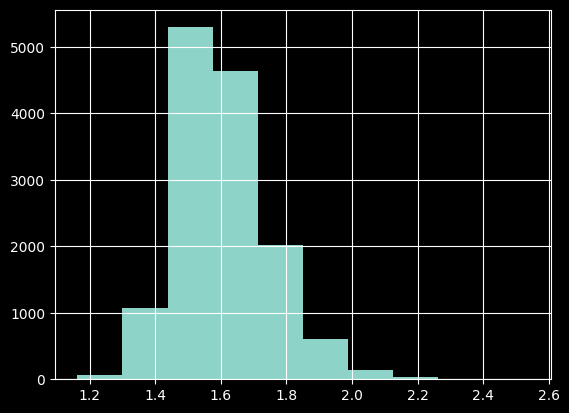

In [29]:
ch.hist()

In [30]:
def add_blood_pressure(df):
  df['blood_pressure'] = df['systolic'] / df['relaxation']
  ranges = [0, 0.9, 1.2, 1.5, 1.8, float('inf')]
  categories = ['very_good', 'good', 'average', 'poor', 'very_poor']
  df['cat_blood_pressure'] = pd.cut(df['blood_pressure'], bins=ranges, labels=categories)

In [31]:
add_blood_pressure(df)
add_blood_pressure(test)

##4. Vision:
   Create a feature that considers the average eyesight between both eyes:

   <b><i>average_eyesight = (eyesight(left) + eyesight(right)) / 2</i></b>




In [32]:
phik_corr_features(['eyesight_left', 'eyesight_right'], 'smoking')

interval columns not set, guessing: ['eyesight_left', 'eyesight_right', 'smoking']


,smoking
eyesight_left,0.0
eyesight_right,0.0


In [33]:
df['eyesight_avg'] = (df['eyesight_left'] + df['eyesight_right'])/2
test['eyesight_avg'] = (test['eyesight_left'] + test['eyesight_right'])/2

##5. Hearing:
   Create a feature that considers the average hearing metric between both ears:

   <b><i>average_hearing = (hearing(left) + hearing(right)) / 2</i></b>



In [35]:
phik_corr_features(['hearing_left', 'hearing_right'], 'smoking')

interval columns not set, guessing: ['hearing_left', 'hearing_right', 'smoking']


,smoking
hearing_left,0.04
hearing_right,0.02


In [36]:
df['hearing_avg'] = (df['hearing_left'] + df['hearing_right'])/2
test['hearing_avg'] = (test['hearing_left'] + test['hearing_right'])/2

##6. Cholesterol Ratios:
   Create ratios between cholesterol and high-density lipoprotein (HDL) or low-density lipoprotein (LDL), for example:

   <b><i>cholesterol_to_hdl_ratio = cholesterol / hdl</i></b>
   
   <b><i>cholesterol_to_ldl_ratio = cholesterol / ldl</i></b>

   Cholesterol-to-HDL Ratio:
   - Very Good: < 2.0
   - Good: 2.0 - 3.0
   - Average: 3.1 - 4.0
   - Poor: 4.1 - 5.0
   - Very Poor: ≥ 5.1



In [37]:
phik_corr_features(['cholesterol', 'hdl', 'ldl'], 'smoking')

interval columns not set, guessing: ['cholesterol', 'hdl', 'ldl', 'smoking']


,smoking
hdl,0.05
ldl,0.02
cholesterol,0.02


In [38]:
ch = df['cholesterol'] / df['hdl']
ch.describe()

count    13863.000000
mean         3.755039
std          1.178365
min          0.559889
25%          2.986206
50%          3.642857
75%          4.400000
max         52.500000
dtype: float64

<Axes: >

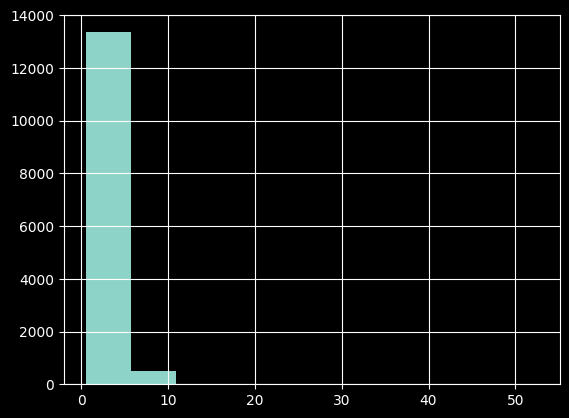

In [39]:
ch.hist()

In [40]:
ch = df['cholesterol'] / df['ldl']
ch.describe()

count    13863.000000
mean         1.784659
std          0.430645
min          0.143284
25%          1.560000
50%          1.692308
75%          1.894484
max         15.714286
dtype: float64

<Axes: >

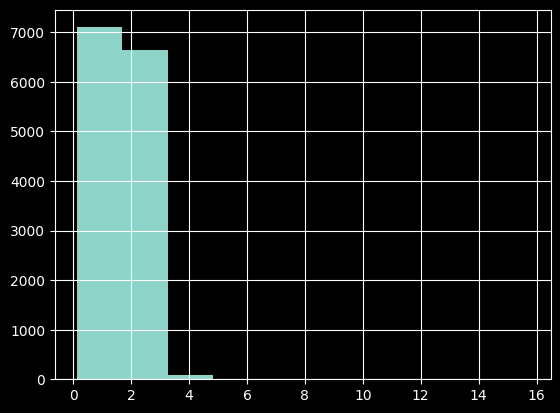

In [41]:
ch.hist()

In [42]:
def add_cholesterol_ratio(df):
  ranges_hdl = [0, 3.0, 4.0, 5.0, 6.0, float('inf')]
  ranges_ldl = [0, 1.0, 2.0, 3.0, 4.0, float('inf')]
  categories = ['very_good', 'good', 'average', 'poor', 'very_poor']

  df['cholesterol_to_hdl_ratio'] = df['cholesterol'] / df['hdl']
  df['cholesterol_to_ldl_ratio'] = df['cholesterol'] / df['ldl']
  df['cat_cholesterol_to_hdl_ratio'] = pd.cut(df['cholesterol_to_hdl_ratio'], bins=ranges_hdl, labels=categories)
  df['cat_cholesterol_to_ldl_ratio'] = pd.cut(df['cholesterol_to_ldl_ratio'], bins=ranges_ldl, labels=categories)

In [43]:
add_cholesterol_ratio(df)
add_cholesterol_ratio(test)

##7. Urine Protein:
   Create a ratio between urine protein and serum creatinine:

   <b><i>protein_to_creatinine_ratio = urine_protein / serum_creatinine</i></b>
  
  Protein-to-Creatinine Ratio:
   - Very Good: < 0.1
   - Good: 0.1 - 0.2
   - Average: 0.3 - 0.4
   - Poor: 0.5 - 0.6
   - Very Poor: ≥ 0.7


In [44]:
phik_corr_features(['urine_protein','serum_creatinine'], 'smoking')

interval columns not set, guessing: ['urine_protein', 'serum_creatinine', 'smoking']


,smoking
serum_creatinine,0.06
urine_protein,0.03


In [45]:
ch = df['urine_protein'] / df['serum_creatinine']
ch.describe()

count    13863.000000
mean         1.154677
std          0.619274
min          0.100000
25%          0.909091
50%          1.000000
75%          1.250000
max         30.000000
dtype: float64

<Axes: >

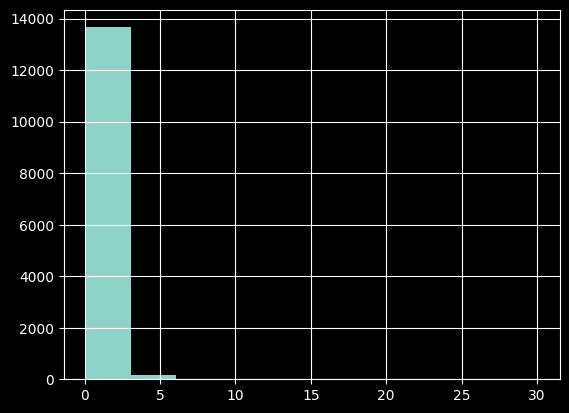

In [46]:
ch.hist()

In [47]:
def add_protein_to_creatinine_ratio(df):
  df['protein_to_creatinine_ratio'] = df['urine_protein'] / df['serum_creatinine']

add_protein_to_creatinine_ratio(df)
add_protein_to_creatinine_ratio(test)

##8. Dental care:

In [48]:
phik_corr_features(['dental_caries', 'tartar'], 'smoking')

interval columns not set, guessing: ['dental_caries', 'smoking']


,smoking
tartar,0.10
dental_caries,0.09


<Axes: >

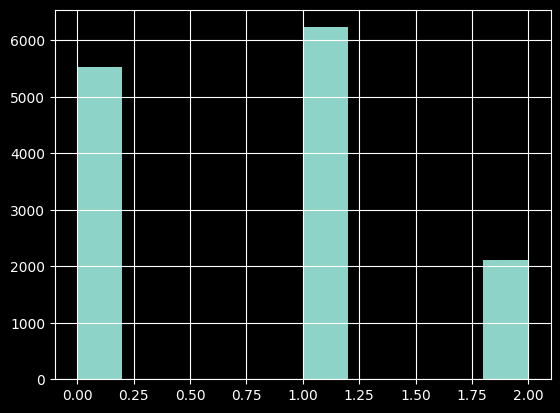

In [49]:
df['tartar'] = (df['tartar'] == 'Y').astype('int')

ch = df['tartar'] + df['dental_caries']
ch.hist()

In [50]:
ch.nunique()

3

In [51]:
df['tartar'] = (df['tartar'] == 'Y').astype('int')
test['tartar'] = (test['tartar'] == 'Y').astype('int')

def add_dental_health(df):
  df['dental_health'] = df['tartar'] + df['dental_caries']
  ranges = [-0.5, 0.5, 1.5, 2.5]
  categories = ['very_good', 'average', 'very_poor']
  df['cat_dental_health'] = pd.cut(df['dental_health'], bins=ranges, labels=categories)

add_dental_health(df)
add_dental_health(test)

In [52]:
df.columns

Index(['id', 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'oral', 'dental_caries', 'tartar', 'smoking', 'bmi',
       'cat_bmi', 'waist_to_height_ratio', 'cat_waist_to_height_ratio',
       'blood_pressure', 'cat_blood_pressure', 'eyesight_avg', 'hearing_avg',
       'cholesterol_to_hdl_ratio', 'cholesterol_to_ldl_ratio',
       'cat_cholesterol_to_hdl_ratio', 'cat_cholesterol_to_ldl_ratio',
       'protein_to_creatinine_ratio', 'dental_health', 'cat_dental_health'],
      dtype='object')

In [62]:
df.select_dtypes(include='category').columns

Index(['cat_bmi', 'cat_waist_to_height_ratio', 'cat_blood_pressure',
       'cat_cholesterol_to_hdl_ratio', 'cat_cholesterol_to_ldl_ratio',
       'cat_dental_health'],
      dtype='object')

#Splited data by train and validation data, in proportion 80/20

In [53]:
train, val = train_test_split(df, train_size=0.80, random_state=42, stratify=df['smoking'])

In [54]:
train.smoking.mean()

0.20198376916140667

In [55]:
val.smoking.mean()


0.2019473494410386

In [71]:
X = ['id', 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'tartar']


y = ["smoking"]

# cat_features = ['tartar']

In [63]:
X_1 = ['age', 'height_cm', 'weight_kg', 'waist_cm', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'tartar', 'bmi',
       'cat_bmi', 'waist_to_height_ratio', 'cat_waist_to_height_ratio',
       'blood_pressure', 'cat_blood_pressure', 'eyesight_avg', 'hearing_avg',
       'cholesterol_to_hdl_ratio', 'cholesterol_to_ldl_ratio',
       'cat_cholesterol_to_hdl_ratio', 'cat_cholesterol_to_ldl_ratio',
       'protein_to_creatinine_ratio', 'dental_health', 'cat_dental_health']


y = ["smoking"]

cat_features_1 = ['cat_bmi', 'cat_waist_to_height_ratio', 'cat_blood_pressure',
       'cat_cholesterol_to_hdl_ratio', 'cat_cholesterol_to_ldl_ratio',
       'cat_dental_health']

In [70]:
# phik_corr_features(X_1, 'smoking')
df.dtypes

id                                int64
age                               int64
height_cm                         int64
weight_kg                         int64
waist_cm                        float64
eyesight_left                   float64
eyesight_right                  float64
hearing_left                    float64
hearing_right                   float64
systolic                        float64
relaxation                      float64
fasting_blood_sugar             float64
cholesterol                     float64
triglyceride                    float64
hdl                             float64
ldl                             float64
hemoglobin                      float64
urine_protein                   float64
serum_creatinine                float64
ast                             float64
alt                             float64
gtp                             float64
oral                             object
dental_caries                     int64
tartar                            int64


In [68]:
df[cat_features_1] = df[cat_features_1].astype('str')
test[cat_features_1] = test[cat_features_1].astype('str')

In [72]:
train_data = Pool(data=train[X],
                  label=train[y],
                  # cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  # cat_features=cat_features
                 )

train_full_data = Pool(data=df[X],
                  label=df[y],
                  # cat_features=cat_features
                 )

In [73]:
train_data_1 = Pool(data=train[X_1],
                  label=train[y],
                  cat_features=cat_features_1
                 )

valid_data_1 = Pool(data=val[X_1],
                  label=val[y],
                  cat_features=cat_features_1
                 )

train_full_data_1 = Pool(data=df[X_1],
                  label=df[y],
                  cat_features=cat_features_1
                 )

In [84]:
params = {
    # 'cat_features': cat_features,
    # 'iterations': model.best_iteration_ + 1,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'learning_rate': 0.011,
    'random_seed': 42,
    'verbose':100
}

params_1 = {
    # 'iterations': model_1.best_iteration_ + 1,
    'cat_features': cat_features_1,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'learning_rate': 0.01,
    'random_seed': 42,
    'verbose':100
}

In [81]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.7126261527
bestIteration = 956

Training on fold [1/5]

bestTest = 0.7036544378
bestIteration = 997

Training on fold [2/5]

bestTest = 0.7120543518
bestIteration = 833

Training on fold [3/5]

bestTest = 0.7054075138
bestIteration = 992

Training on fold [4/5]

bestTest = 0.6743417016
bestIteration = 990



In [82]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
993,993,0.701474,0.015668,0.459853,0.006981,0.397491,0.002782


In [77]:
cv_data = cv(
    params = params_1,
    pool = train_data_1,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.7141660509
bestIteration = 995

Training on fold [1/5]

bestTest = 0.6988861289
bestIteration = 998

Training on fold [2/5]

bestTest = 0.7137238155
bestIteration = 991

Training on fold [3/5]

bestTest = 0.7026577773
bestIteration = 984

Training on fold [4/5]

bestTest = 0.6799621638
bestIteration = 995



In [78]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
990,990,0.701784,0.014027,0.460261,0.007382,0.409113,0.002914


In [85]:
model_train = CatBoostClassifier(**params)
model_full = CatBoostClassifier(**params)

model_train_1 = CatBoostClassifier(**params_1)
model_full_1 = CatBoostClassifier(**params_1)

In [87]:
model_train.fit(train_data, eval_set=valid_data)
model_full.fit(train_full_data)

0:	test: 0.5750052	best: 0.5750052 (0)	total: 8.54ms	remaining: 8.53s
100:	test: 0.6843433	best: 0.6843433 (100)	total: 769ms	remaining: 6.84s
200:	test: 0.7040217	best: 0.7040217 (200)	total: 1.54s	remaining: 6.12s
300:	test: 0.7145165	best: 0.7145165 (300)	total: 2.29s	remaining: 5.32s
400:	test: 0.7197849	best: 0.7198357 (397)	total: 3.85s	remaining: 5.75s
500:	test: 0.7246748	best: 0.7246748 (500)	total: 5.52s	remaining: 5.5s
600:	test: 0.7271843	best: 0.7271843 (600)	total: 6.26s	remaining: 4.16s
700:	test: 0.7279896	best: 0.7280300 (686)	total: 6.96s	remaining: 2.97s
800:	test: 0.7288910	best: 0.7289507 (795)	total: 7.69s	remaining: 1.91s
900:	test: 0.7298310	best: 0.7299053 (899)	total: 8.43s	remaining: 926ms
999:	test: 0.7304120	best: 0.7306283 (991)	total: 9.14s	remaining: 0us

bestTest = 0.730628268
bestIteration = 991

Shrink model to first 992 iterations.
0:	total: 8.39ms	remaining: 8.38s
100:	total: 744ms	remaining: 6.62s
200:	total: 1.5s	remaining: 5.97s
300:	total: 2.25s

In [88]:
model_train_1.fit(train_data_1, eval_set=valid_data_1)
model_full_1.fit(train_full_data_1)

0:	test: 0.5899131	best: 0.5899131 (0)	total: 32.3ms	remaining: 32.3s
100:	test: 0.6848009	best: 0.6851325 (98)	total: 3.28s	remaining: 29.2s
200:	test: 0.6992810	best: 0.6992810 (200)	total: 6.96s	remaining: 27.7s
300:	test: 0.7105327	best: 0.7105779 (299)	total: 9.74s	remaining: 22.6s
400:	test: 0.7159359	best: 0.7159359 (400)	total: 12.5s	remaining: 18.7s
500:	test: 0.7189029	best: 0.7189037 (498)	total: 15.3s	remaining: 15.2s
600:	test: 0.7211026	best: 0.7212325 (596)	total: 19.2s	remaining: 12.8s
700:	test: 0.7224824	best: 0.7225244 (698)	total: 21.9s	remaining: 9.34s
800:	test: 0.7237654	best: 0.7237856 (799)	total: 26.7s	remaining: 6.64s
900:	test: 0.7244828	best: 0.7245723 (890)	total: 30.6s	remaining: 3.36s
999:	test: 0.7253865	best: 0.7254115 (993)	total: 33.4s	remaining: 0us

bestTest = 0.7254115293
bestIteration = 993

Shrink model to first 994 iterations.
0:	total: 34.5ms	remaining: 34.4s
100:	total: 3.11s	remaining: 27.7s
200:	total: 6.07s	remaining: 24.1s
300:	total: 10.

In [90]:
model_train.predict_proba(train_data)[:, 1]
model_full.predict_proba(train_full_data)[:, 1]

model_train_1.predict_proba(train_data_1)[:, 1]
model_full_1.predict_proba(train_full_data_1)[:, 1]

array([0.16478847, 0.28250282, 0.10172648, ..., 0.2221039 , 0.14569144,
       0.07122533])

In [91]:
df['y_score'] = model_full.predict_proba(df[X])[:, 1]
df['y_score_1'] = model_full_1.predict_proba(df[X_1])[:, 1]


train['y_score'] = model_train.predict_proba(train_data)[:, 1]
train['y_score_1'] = model_train_1.predict_proba(train_data_1)[:, 1]

In [95]:
train[train.id ==  12267]

,id,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,hearing_avg,cholesterol_to_hdl_ratio,cholesterol_to_ldl_ratio,cat_cholesterol_to_hdl_ratio,cat_cholesterol_to_ldl_ratio,protein_to_creatinine_ratio,dental_health,cat_dental_health,y_score,y_score_1
2378,12267,40,170,85,93.0,1.2,1.5,1.0,1.0,143.0,...,1.0,4.222222,1.96129,average,good,5.0,0,very_good,0.295271,0.315053


In [94]:
df[df.id ==  12267]

,id,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,hearing_avg,cholesterol_to_hdl_ratio,cholesterol_to_ldl_ratio,cat_cholesterol_to_hdl_ratio,cat_cholesterol_to_ldl_ratio,protein_to_creatinine_ratio,dental_health,cat_dental_health,y_score,y_score_1
2378,12267,40,170,85,93.0,1.2,1.5,1.0,1.0,143.0,...,1.0,4.222222,1.96129,average,good,5.0,0,very_good,0.334335,0.337402


In [96]:
thresholds = np.linspace(0, 1, num=101)

In [ ]:
# thresholds

In [ ]:
# df['y_score'].hist()

In [101]:
thresholds = np.linspace(0, 1, num=101)
f1_scores = []
f1_scores_train = []
f1_scores_1 = []
f1_scores_train_1 = []

for threshold in tqdm(thresholds):
    y_pred = (df['y_score'] >= threshold).astype(int)
    f1 = f1_score(df['smoking'], y_pred)
    f1_scores.append(f1)

    y_pred = (train['y_score'] >= threshold).astype(int)
    f1 = f1_score(train['smoking'], y_pred)
    f1_scores_train.append(f1)

    y_pred = (df['y_score_1'] >= threshold).astype(int)
    f1 = f1_score(df['smoking'], y_pred)
    f1_scores_1.append(f1)

    y_pred = (train['y_score_1'] >= threshold).astype(int)
    f1 = f1_score(train['smoking'], y_pred)
    f1_scores_train_1.append(f1)

results_df = pd.DataFrame({'threshold': thresholds, 'f1': f1_scores})

results_train_df = pd.DataFrame({'threshold': thresholds, 'f1': f1_scores_train})

results_df_1 = pd.DataFrame({'threshold': thresholds, 'f1': f1_scores_1})

results_train_df_1 = pd.DataFrame({'threshold': thresholds, 'f1': f1_scores_train_1})

  0%|          | 0/101 [00:00<?, ?it/s]

In [102]:
# results_df
# len(f1_scores)

In [104]:
max_f1_row = results_df.loc[results_df['f1'].idxmax()]
max_f1_row_1 = results_df.loc[results_df_1['f1'].idxmax()]

In [105]:
max_train_f1_row = results_df.loc[results_train_df['f1'].idxmax()]
max_train_f1_row_1 = results_df.loc[results_train_df_1['f1'].idxmax()]

In [106]:
max_f1_row

threshold    0.250000
f1           0.532309
Name: 25, dtype: float64

In [108]:
max_f1_row_1

threshold    0.250000
f1           0.532309
Name: 25, dtype: float64

In [107]:
max_train_f1_row

threshold    0.260000
f1           0.530754
Name: 26, dtype: float64

In [109]:
max_train_f1_row_1

threshold    0.240000
f1           0.530052
Name: 24, dtype: float64

In [111]:
unique_y_scores = sorted(df['y_score'].unique())
unique_train_y_scores = sorted(train['y_score'].unique())

unique_y_scores_1 = sorted(df['y_score_1'].unique())
unique_train_y_scores_1 = sorted(train['y_score_1'].unique())

In [112]:
f1_scores = []
f1_train_scores = []
f1_scores_1 = []
f1_train_scores_1 = []

for threshold in tqdm(unique_y_scores):
    y_pred = (df['y_score'] >= threshold).astype(int)
    f1 = f1_score(df['smoking'], y_pred)
    f1_scores.append(f1)

for threshold in tqdm(unique_train_y_scores):
    y_pred = (df['y_score'] >= threshold).astype(int)
    f1 = f1_score(df['smoking'], y_pred)
    f1_train_scores.append(f1)

for threshold in tqdm(unique_y_scores_1):
    y_pred = (df['y_score_1'] >= threshold).astype(int)
    f1 = f1_score(df['smoking'], y_pred)
    f1_scores_1.append(f1)

for threshold in tqdm(unique_train_y_scores_1):
    y_pred = (df['y_score_1'] >= threshold).astype(int)
    f1 = f1_score(df['smoking'], y_pred)
    f1_train_scores_1.append(f1)


results_df_unq = pd.DataFrame({'threshold': unique_y_scores, 'f1': f1_scores})
results_train_df_unq = pd.DataFrame({'threshold': unique_train_y_scores, 'f1': f1_train_scores})

results_df_unq_1 = pd.DataFrame({'threshold': unique_y_scores_1, 'f1': f1_scores_1})
results_train_df_unq_1 = pd.DataFrame({'threshold': unique_train_y_scores_1, 'f1': f1_train_scores_1})


  0%|          | 0/13843 [00:00<?, ?it/s]

  0%|          | 0/11076 [00:00<?, ?it/s]

  0%|          | 0/12209 [00:00<?, ?it/s]

  0%|          | 0/10024 [00:00<?, ?it/s]

In [115]:
max_f1_row_unq = results_df_unq.loc[results_df_unq['f1'].idxmax()]
max_train_f1_row_unq = results_df_unq.loc[results_train_df_unq['f1'].idxmax()]

max_f1_row_unq_1 = results_df_unq_1.loc[results_df_unq_1['f1'].idxmax()]
max_train_f1_row_unq_1 = results_df_unq_1.loc[results_train_df_unq_1['f1'].idxmax()]

In [116]:
max_f1_row_unq

threshold    0.254913
f1           0.533871
Name: 10445, dtype: float64

In [117]:
max_f1_row_unq_1

threshold    0.247595
f1           0.520437
Name: 8920, dtype: float64

In [118]:
max_train_f1_row_unq

threshold    0.201631
f1           0.507510
Name: 8394, dtype: float64

In [119]:
max_train_f1_row_unq_1

threshold    0.208402
f1           0.502367
Name: 7487, dtype: float64

In [122]:
# model.get_feature_importance(prettified=True)
df.head(1)

,id,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,hearing_avg,cholesterol_to_hdl_ratio,cholesterol_to_ldl_ratio,cat_cholesterol_to_hdl_ratio,cat_cholesterol_to_ldl_ratio,protein_to_creatinine_ratio,dental_health,cat_dental_health,y_score,y_score_1
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,...,1.0,1.676056,2.288462,very_good,average,2.5,0,very_good,0.161474,0.164788


In [123]:
df['pred_smoking_thres'] = (df['y_score'] >= max_f1_row[0])* 1
df['pred_smoking_unq'] = (df['y_score'] >= max_f1_row_unq[0])* 1
df['pred_smoking_unq_1'] = (df['y_score_1'] >= max_f1_row_unq_1[0])* 1

df['pred_train_smoking'] = (df['y_score'] >= max_train_f1_row[0])* 1
df['pred_train_smoking_unq'] = (df['y_score'] >= max_train_f1_row_unq[0])* 1
df['pred_train_smoking_unq_1'] = (df['y_score_1'] >= max_train_f1_row_unq_1[0])* 1

In [124]:
df

,id,age,height_cm,weight_kg,waist_cm,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,...,dental_health,cat_dental_health,y_score,y_score_1,pred_smoking_thres,pred_smoking_unq,pred_smoking_unq_1,pred_train_smoking,pred_train_smoking_unq,pred_train_smoking_unq_1
0,2791,65,170,75,91.0,0.6,0.9,1.0,1.0,122.0,...,0,very_good,0.161474,0.164788,0,0,0,0,0,0
1,18280,35,170,85,97.0,1.5,1.5,1.0,1.0,138.0,...,0,very_good,0.337392,0.282503,1,1,1,1,1,1
2,1618,70,165,55,75.0,0.8,1.0,1.0,1.0,115.0,...,0,very_good,0.088415,0.101726,0,0,0,0,0,0
3,16856,35,180,85,83.0,1.2,1.0,1.0,1.0,130.0,...,0,very_good,0.171565,0.177706,0,0,0,0,0,0
4,5885,25,170,65,80.0,1.5,1.2,1.0,1.0,135.0,...,0,very_good,0.146900,0.141246,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13858,7835,45,175,85,94.0,0.8,0.8,1.0,1.0,127.0,...,0,very_good,0.235955,0.244277,0,0,0,0,1,1
13859,9335,40,170,75,86.0,1.2,1.0,1.0,1.0,134.0,...,0,very_good,0.392212,0.367334,1,1,1,1,1,1
13860,18936,65,170,70,85.0,0.6,0.7,1.0,1.0,131.0,...,1,average,0.305467,0.222104,1,1,0,1,1,1
13861,11064,30,160,80,89.0,1.5,1.5,1.0,1.0,120.0,...,0,very_good,0.148338,0.145691,0,0,0,0,0,0


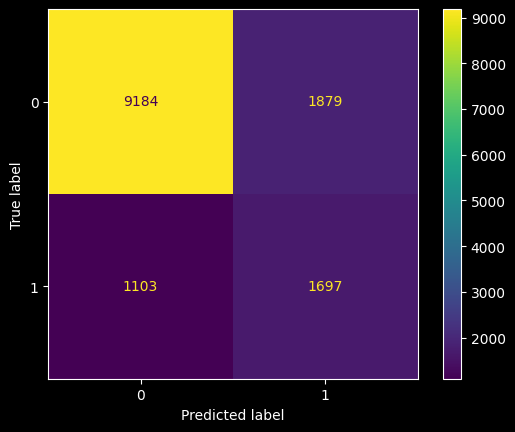

In [125]:
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_smoking_thres'])).plot();

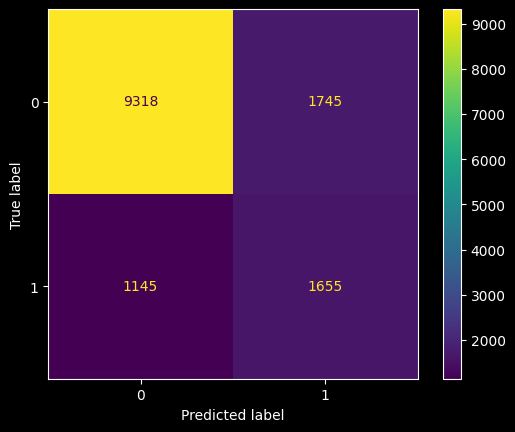

In [126]:
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_smoking_unq'])).plot();

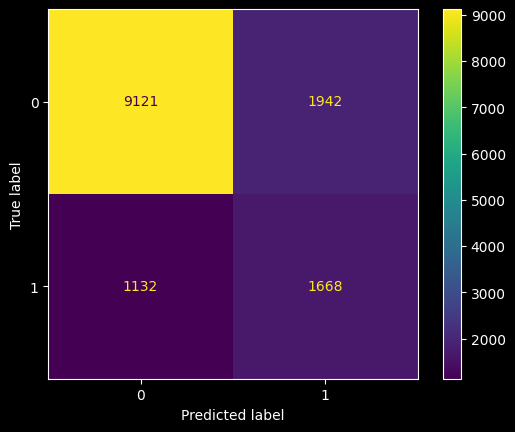

In [127]:
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_smoking_unq_1'])).plot();


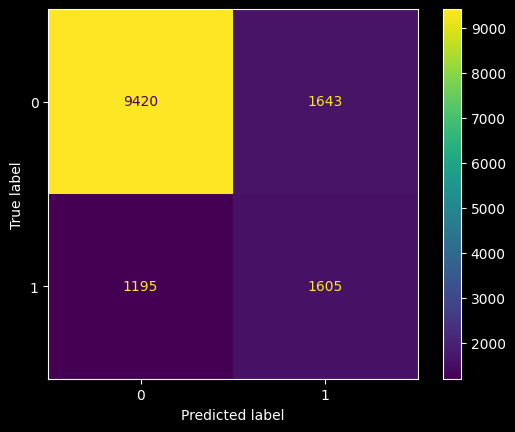

In [128]:
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_train_smoking'])).plot();


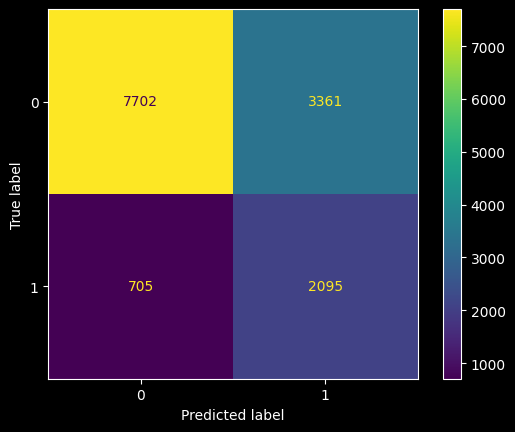

In [129]:
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_train_smoking_unq'])).plot();


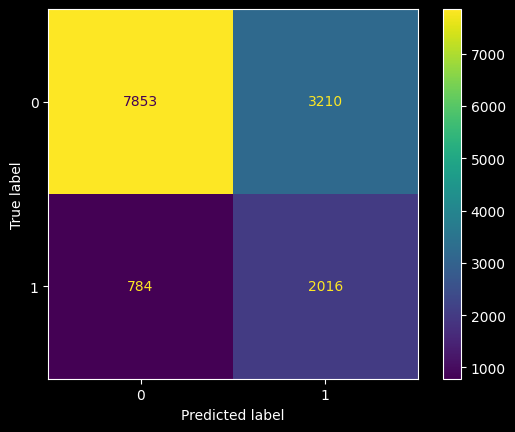

In [130]:
ConfusionMatrixDisplay(confusion_matrix(df['smoking'], df['pred_train_smoking_unq_1'])).plot();


In [131]:
print(classification_report(df['smoking'], df['pred_smoking_thres']))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86     11063
           1       0.47      0.61      0.53      2800

    accuracy                           0.78     13863
   macro avg       0.68      0.72      0.70     13863
weighted avg       0.81      0.78      0.79     13863



In [145]:
print(classification_report(df['smoking'], df['pred_train_smoking']))


              precision    recall  f1-score   support

           0       0.89      0.85      0.87     11063
           1       0.49      0.57      0.53      2800

    accuracy                           0.80     13863
   macro avg       0.69      0.71      0.70     13863
weighted avg       0.81      0.80      0.80     13863



In [132]:
print(classification_report(df['smoking'], df['pred_smoking_unq']))


              precision    recall  f1-score   support

           0       0.89      0.84      0.87     11063
           1       0.49      0.59      0.53      2800

    accuracy                           0.79     13863
   macro avg       0.69      0.72      0.70     13863
weighted avg       0.81      0.79      0.80     13863



In [146]:
print(classification_report(df['smoking'], df['pred_train_smoking_unq']))


              precision    recall  f1-score   support

           0       0.92      0.70      0.79     11063
           1       0.38      0.75      0.51      2800

    accuracy                           0.71     13863
   macro avg       0.65      0.72      0.65     13863
weighted avg       0.81      0.71      0.73     13863



In [133]:
print(classification_report(df['smoking'], df['pred_smoking_unq_1']))


              precision    recall  f1-score   support

           0       0.89      0.82      0.86     11063
           1       0.46      0.60      0.52      2800

    accuracy                           0.78     13863
   macro avg       0.68      0.71      0.69     13863
weighted avg       0.80      0.78      0.79     13863



In [148]:
print(classification_report(df['smoking'], df['pred_train_smoking_unq_1']))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80     11063
           1       0.39      0.72      0.50      2800

    accuracy                           0.71     13863
   macro avg       0.65      0.71      0.65     13863
weighted avg       0.80      0.71      0.74     13863



In [134]:
test['y_score'] = model_full.predict_proba(test[X])[:, 1]
test['y_score_1'] = model_full_1.predict_proba(test[X_1])[:, 1]

In [144]:
test['smoking'] = (test['y_score_1'] >= (test['y_score_1'] >= max_f1_row_unq_1[0])* 1


# test['pred_smoking_thres'] = (test['y_score'] >= max_f1_row[0])* 1         # res_1.csv
# test['pred_smoking_thres_1'] = (test['y_score_1'] >= max_f1_row_1[0])* 1   # res_2.csv
# test['pred_smoking_unq'] = (test['y_score'] >= max_f1_row_unq[0])* 1       # res_3.csv
# test['pred_smoking_unq_1'] = (test['y_score_1'] >= max_f1_row_unq_1[0])* 1 # res_4.csv

# test['pred_train_smoking'] = (test['y_score'] >= max_train_f1_row[0])* 1   # res_5.csv
# test['pred_train_smoking_1'] = (test['y_score'] >= max_train_f1_row[0])* 1             # res_6.csv
# test['pred_train_smoking_unq'] = (test['y_score'] >= max_train_f1_row_unq[0])* 1       # res_7.csv
# test['pred_train_smoking_unq_1'] = (test['y_score_1'] >= max_train_f1_row_unq_1[0])* 1   # res_8.csv

res_df = test.loc[:, ['id', 'smoking']]
res_df.to_csv(r'res_8.csv', index=False)

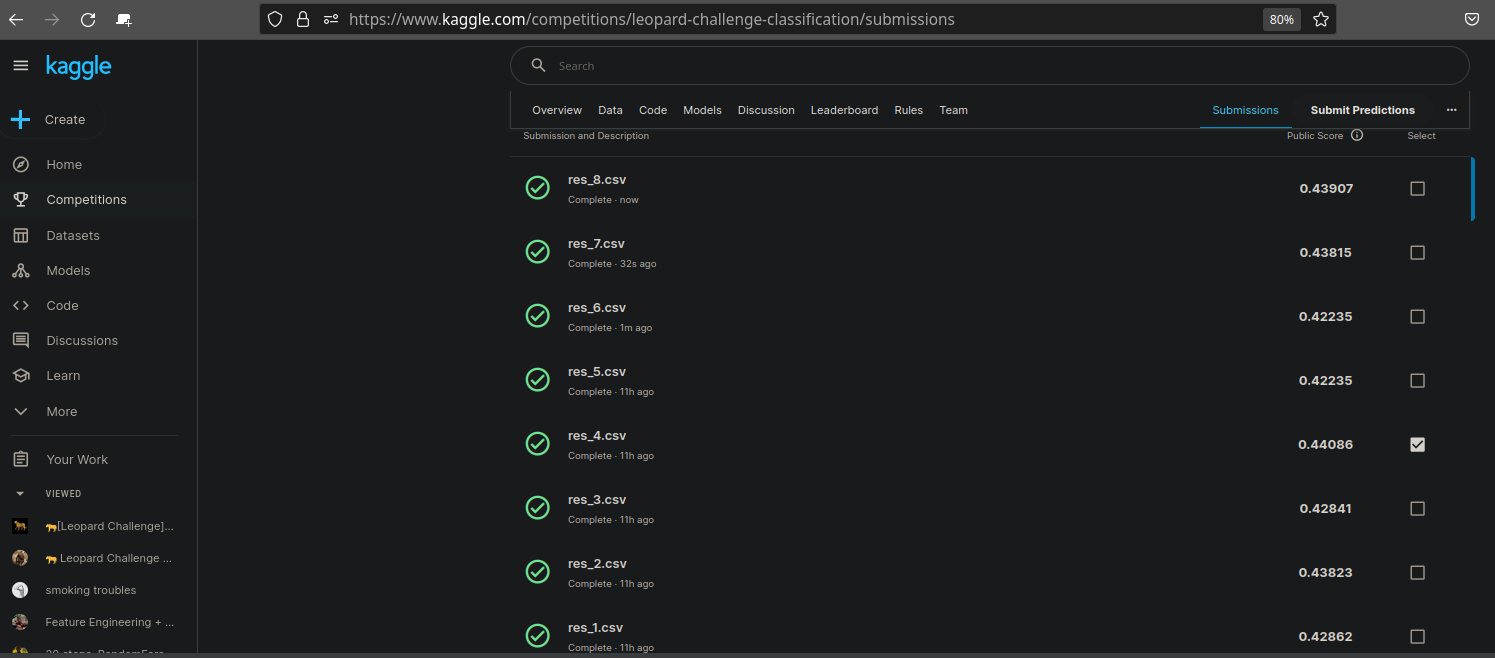

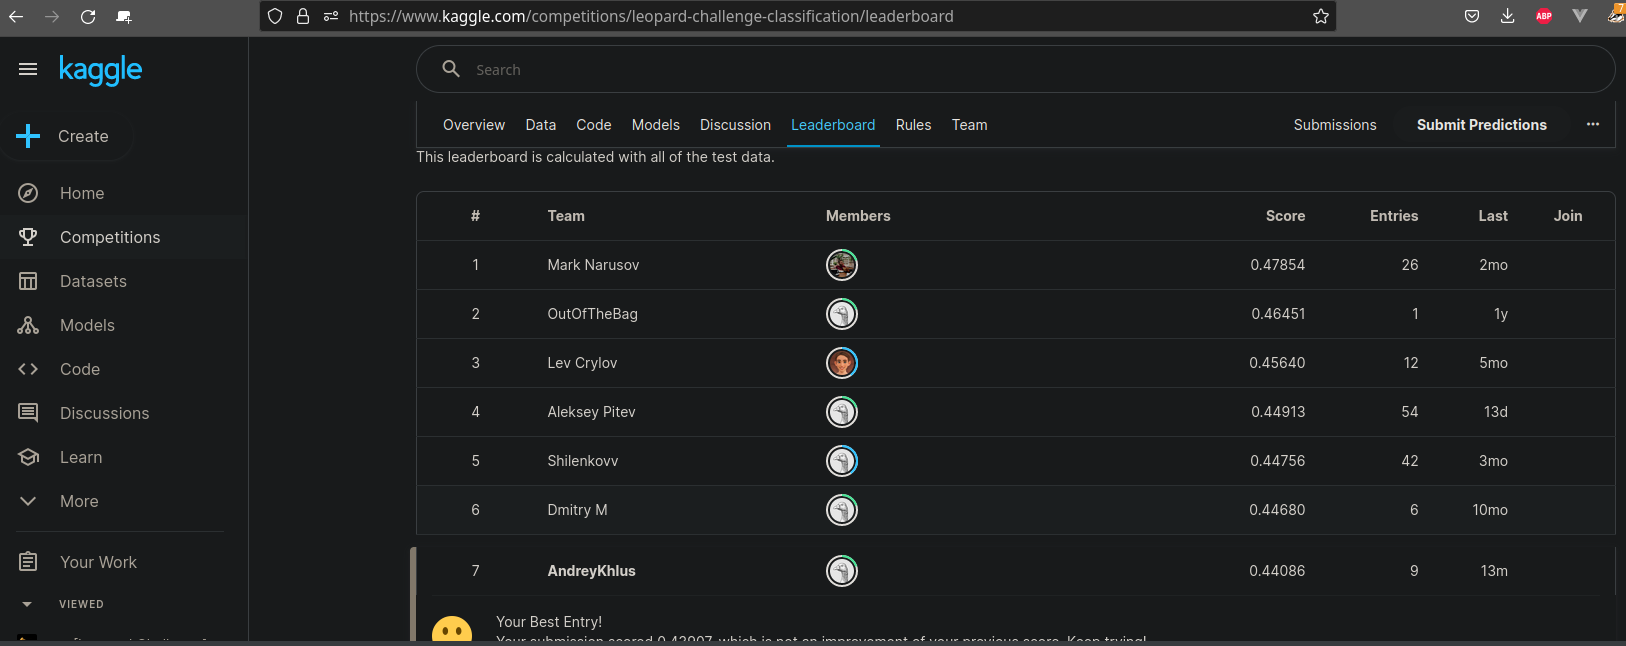